In [ ]:
# Removendo defeitos por movimento


Esse tipo de efeito pode ser simulado através do que é conhecido como Point spread functions


## Simulando deterioação por movimento

In [ ]:
import numpy as np
from numba import prange, njit, jit
from scipy.signal import convolve2d
from scipy.signal import convolve
from scipy import fft
import matplotlib.pyplot as plt
import cv2 

@njit(parallel=True)
def get_motion_psf(
        dim_x: int, dim_y: int, degree_angle: float, num_pixel_dist: int)-> np.ndarray:
    """Essa função retorna uma array representando a PSF para um dado ângulo em graus

    Parameters:
    -----------
        dim_x: int
            The width of the image.
        dim_y: int
            The height of the image.
        degree_angle: float
            The angle of the motion blur. Should be in degrees. [0, 360)
        num_pixel_dist: int
            The distance of the motion blur. [0, \infinity).
            Remember that the distance is measured in pixels.
            Greater will be more blurry.
    
    Returns:
    --------
        np.ndarray
            The point-spread array associated with the motion blur.

    """
    psf = np.zeros((dim_x, dim_y))
    center = np.array([dim_x-1, dim_y-1])//2
    radians = degree_angle/180*np.pi
    phase = np.array([np.cos(radians), np.sin(radians)])
    for i in prange(num_pixel_dist):
        offset_x = int(center[0] - np.round_(i*phase[0]))
        offset_y = int(center[1] - np.round_(i*phase[1]))
        psf[offset_x, offset_y] = 1 
    psf /= psf.sum()
 
    return psf 

Vamos simular um pequeno exemplo de distorção criado por movimento

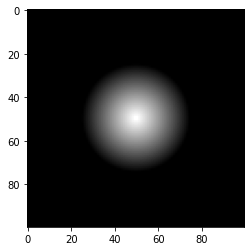

In [ ]:
img = np.zeros((100, 100))
xs = np.linspace(-50, 50, 100)
ys = np.linspace(-50, 50, 100)
X, Y = np.meshgrid(xs, ys)
R = np.sqrt(X**2 + Y**2)
img[R<25] = 25-R[R<25]
img[R>25] = 0
img /= img.max()
img *= 255
img = img.astype("uint8")

plt.imshow(img, cmap="gray")
plt.show()

###  Movimento para diversos ângulos

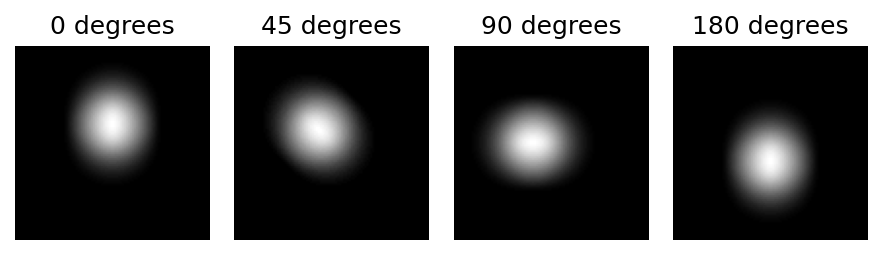

In [ ]:

thetas = [0, 45, 90, 180]

fig, axes = plt.subplots(1, len(thetas), dpi=150)

def normalize(img):
    img = img.astype(np.float64)
    img -= img.min()
    img /= img.max()
    img *= 255
    return img.astype(np.uint8)

for ax, theta in zip(axes, thetas):
    psf = get_motion_psf(img.shape[0], img.shape[1], theta, 20)
    normed_psf = np.zeros(psf.shape)
    kernel = np.ones((5,5),np.float32)/25
    psf = cv2.filter2D(psf,-1,kernel)
    cv2.normalize(psf, normed_psf, 1.0, 0.0, cv2.NORM_MINMAX)

    img_motion = convolve2d(img.astype("float64")/255, normed_psf, mode='same').astype("uint8")
    img_motion = normalize(img_motion)
    cv2.imwrite(f'img_{theta}.jpg', img_motion)
    # psf = np.ones((5, 5), dtype="float64") / 25
    # img_motion = convolve2d(img, psf, 'same')
    ax.imshow(img_motion, cmap="gray")
    ax.set_title(f"{theta} degrees")
    ax.axis('off')
plt.tight_layout()
plt.show()



In [ ]:
!rm *.jpg

### Desfazendo o efeito criado pela PSF

Na atividade passada você aprendeu a utilizar e remover filtros usando a transformada de Fourrier. A ideia aqui é a mesma, a função abaixo desfaz a aplicação da psf.

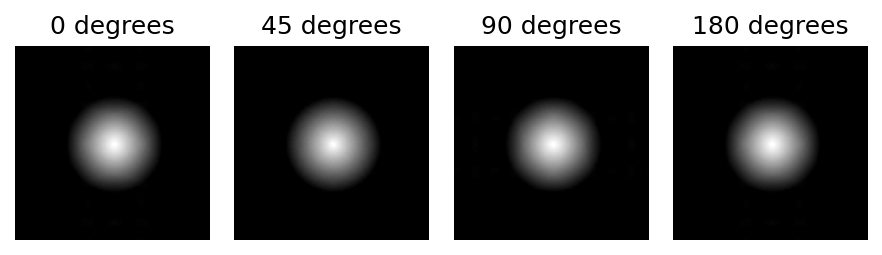

In [ ]:

def remove_psf_effect(
        img: np.ndarray, psf: np.ndarray,
        eps: float = 1e-10)->np.ndarray:       
    psf_fft = fft.fft2 (psf) + eps
    img_resotred = fft.ifft2 (fft.fft2(img)/psf_fft)
    img_resotred = np.abs(fft.fftshift(img_resotred))
    return img_resotred





fig, axes = plt.subplots(1, len(thetas), dpi=150)

for ax, theta in zip(axes, thetas):
    psf = get_motion_psf(img.shape[0], img.shape[1], theta, 20)
    kernel = np.ones((5,5),np.float32)/25
    psf = cv2.filter2D(psf,-1,kernel)
    cv2.normalize(psf, normed_psf, 1.0, 0.0, cv2.NORM_MINMAX)
    normed_psf = np.zeros(psf.shape)
    cv2.normalize(psf, normed_psf, 1.0, 0.0, cv2.NORM_MINMAX)
    img_motion = convolve2d(img.astype("float64")/255, normed_psf, mode='same')
    img_motion_r = remove_psf_effect(img_motion, psf).astype("uint8")
    ax.imshow(img_motion_r, cmap="gray")
    ax.set_title(f"{theta} degrees")
    ax.axis('off')
plt.tight_layout()
plt.show()



### Movimento + ruído

Ok. Você pode questionar o porquê dessa atividade se a inversa da transforamda aparentemente resolve o problema. Veremos abaixo que isso não é o caso quando um pequeno ruído é adicionado na imagem. 

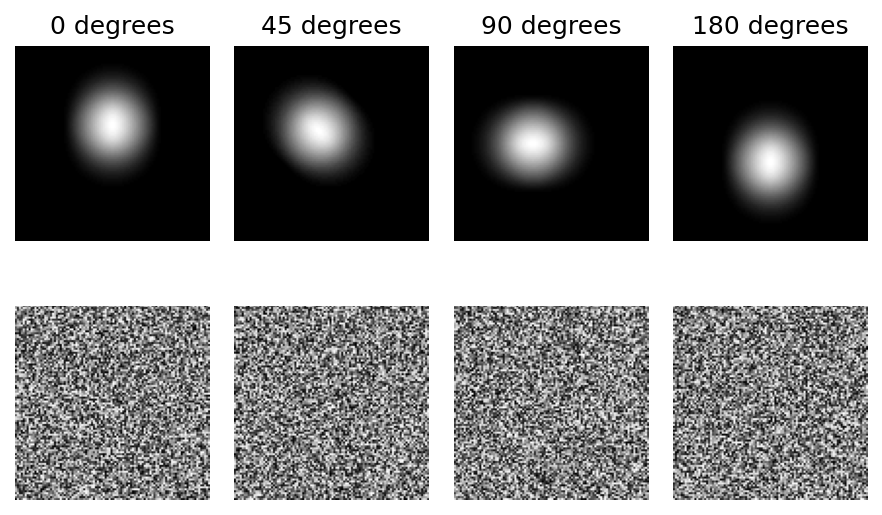

In [ ]:

thetas = [0, 45, 90, 180]

fig, (axes1, axes2) = plt.subplots(2, len(thetas), dpi=150)

for ax, ax_r, theta in zip(axes1, axes2, thetas):
    psf = get_motion_psf(img.shape[0], img.shape[1], theta, 20)
    kernel = np.ones((5,5),np.float32)/25
    psf = cv2.filter2D(psf,-1,kernel)
    cv2.normalize(psf, normed_psf, 1.0, 0.0, cv2.NORM_MINMAX)
    normed_psf = np.zeros(psf.shape)
    cv2.normalize(psf, normed_psf, 1.0, 0.0, cv2.NORM_MINMAX)
    img_motion_float = convolve2d(img.astype("float64")/255, normed_psf, mode='same')
    img_motion_float = img_motion_float + 0.001 * img_motion_float.std() * np.random.normal(0, 1, size=img_motion.shape)
    img_motion_r = remove_psf_effect(img_motion_float, psf).astype("uint8")
    ax.imshow(img_motion_float.astype("uint8"), cmap="gray")
    ax_r.imshow(img_motion_r.astype("uint8"), cmap="gray")

    ax.set_title(f"{theta} degrees")
    ax.axis('off')
    ax_r.axis("off")
plt.tight_layout()
plt.show()



Bem problemático não? A sua tarefa será implementar o filtro de Richardson-Lucy que consegue remover o efeito de uma PSF conhecida mesmo na presença de ruído.  Um exemplo de um método com as assinaturas e argumentos deverá ser parecido com isso

In [ ]:
def richardson_lucy_filter(
        img: np.ndarray, psf: np.ndarray, max_iter: int=50) -> np.ndarray:
    """


    Parameters:
    ----------
        img : np.ndarray
            Your degraded image (grayscale)
        psf : np.ndarray
        max_iter : int
            maximum number of iterations
    Returns
    -------
        np.ndarray
    

    """
    pass

**Mas tome cuidado com o algoritmo, tente observar se alguma condição especial nas iterações pode ocorrer**